In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings

# Configurações globais
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


In [5]:
# Carregar dataset
try:
    df = pd.read_csv("Pokemon Database.csv")
    print("Dataset carregado!")
except FileNotFoundError:
    print("ERRO: 'Pokemon Database.csv' não encontrado. Verifique o caminho do arquivo.")

# Limpeza básica de strings
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.replace('"', '', regex=False)

# Renomear colunas
df = df.rename(columns={
    'Pokedex Number': 'Id', 'Pokemon Name': 'Name', 'Legendary Type': 'Group',
    'Pokemon Height': 'Height', 'Pokemon Weight': 'Weight', 'Health Stat': 'HP',
    'Attack Stat': 'Attack', 'Defense Stat': 'Defense',
    'Special Attack Stat': 'SpAtk', 'Special Defense Stat': 'SpDef',
    'Speed Stat': 'Speed', 'Base Stat Total': 'BST', 'Catch Rate': 'CatchRate'
})

# Tratar nulos na coluna Group
df['Group'] = df['Group'].fillna('Regular')

# Engenharia de Features: Criar Target Binário (1=Especial, 0=Comum)
def classify_legendary(group):
    if group in ['Legendary', 'Mythical', 'Ultra Beast', 'Paradox', 'Pseudo-Legendary']:
        return 1
    return 0

df['is_legendary'] = df['Group'].apply(classify_legendary)

# Seleção de Features e Limpeza final
numeric_features = ['Height', 'Weight', 'HP', 'Attack', 'Defense', 'SpAtk', 'SpDef', 'Speed']
target_reg = 'CatchRate'
target_clf = 'is_legendary'

# Remove linhas com nulos nas colunas que vamos usar
df_model = df.dropna(subset=numeric_features + [target_reg]).copy()

print(f"Shape final do dataset: {df_model.shape}")
print(f"Contagem de Lendários: {df_model['is_legendary'].sum()}")

Dataset carregado!
Shape final do dataset: (1382, 46)
Contagem de Lendários: 87


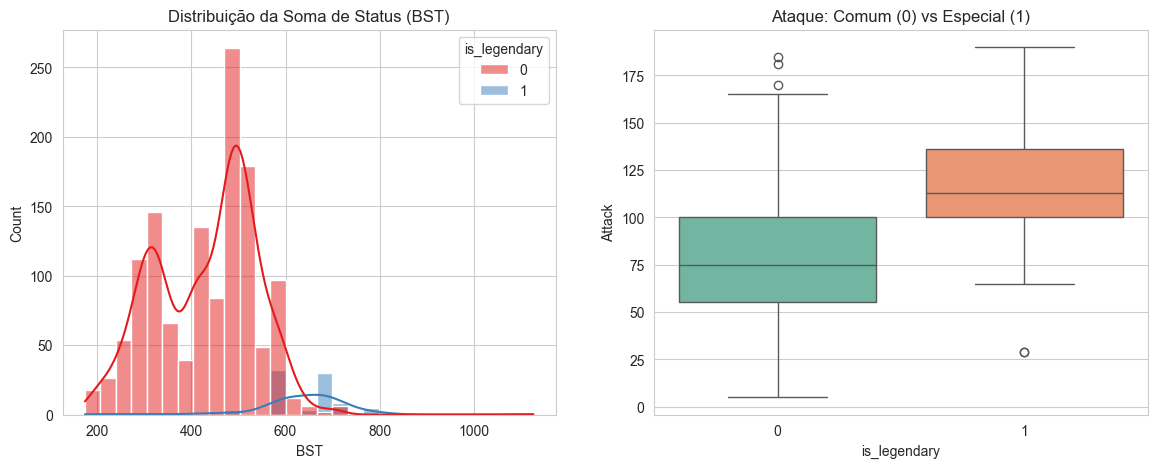

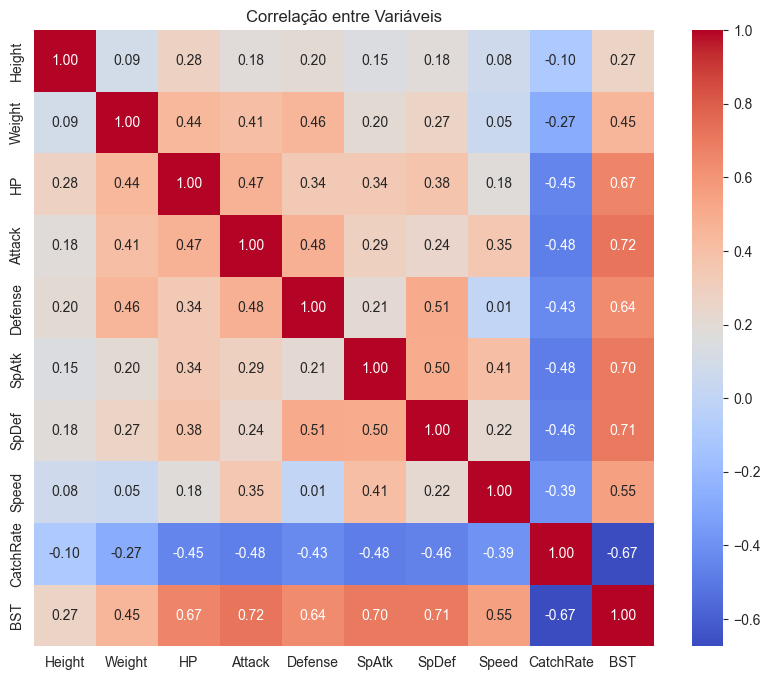


--- Resultado do Teste T ---
Estatística T: 10.6960, P-Valor: 4.3571e-18
>> Diferença Significativa confirmada!


In [6]:
# 1. Visualização: Distribuição de BST
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df_model, x='BST', hue='is_legendary', kde=True, palette='Set1')
plt.title('Distribuição da Soma de Status (BST)')

# 2. Visualização: Boxplot de Ataque
plt.subplot(1, 2, 2)
sns.boxplot(x='is_legendary', y='Attack', data=df_model, palette='Set2')
plt.title('Ataque: Comum (0) vs Especial (1)')
plt.show()

# 3. Matriz de Correlação
plt.figure(figsize=(10, 8))
corr = df_model[numeric_features + ['CatchRate', 'BST']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlação entre Variáveis')
plt.show()

# 4. Teste Estatístico (T-Test)
# Hipótese: "Ataque dos Especiais é maior que dos Comuns?"
group_1 = df_model[df_model['is_legendary'] == 1]['Attack']
group_0 = df_model[df_model['is_legendary'] == 0]['Attack']

t_stat, p_val = stats.ttest_ind(group_1, group_0, equal_var=False)
print(f"\n--- Resultado do Teste T ---\nEstatística T: {t_stat:.4f}, P-Valor: {p_val:.4e}")
if p_val < 0.05:
    print(">> Diferença Significativa confirmada!")
else:
    print(">> Nenhuma diferença significativa encontrada.")

In [7]:
# --- 4. MODELAGEM DE REGRESSÃO (Prever Catch Rate) ---
# Preparar dados para Regressão
X = df_model[numeric_features]
y = df_model[target_reg]

# Divisão Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo OLS (com intercepto) usando statsmodels
# O statsmodels exige adicionar uma constante manualmente para o intercepto
X_train_sm = sm.add_constant(X_train)
model_ols = sm.OLS(y_train, X_train_sm).fit()

# Exibir o sumário estatístico completo
print(model_ols.summary())

# Diagnóstico de Multicolinearidade (VIF)
vif = pd.DataFrame()
vif["Feature"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
print("\n--- Análise de VIF (Multicolinearidade) ---\n", vif)

# Avaliação no Teste
X_test_sm = sm.add_constant(X_test)
y_pred = model_ols.predict(X_test_sm)

# Cálculo das Métricas de Regressão (Corrigido para versões antigas do sklearn)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Raiz quadrada do MSE calculada manualmente com numpy
r2 = r2_score(y_test, y_pred)

print("\n--- Métricas de Regressão (Teste) ---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

                            OLS Regression Results                            
Dep. Variable:              CatchRate   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     122.2
Date:                Sat, 06 Dec 2025   Prob (F-statistic):          5.29e-146
Time:                        20:31:59   Log-Likelihood:                -5970.5
No. Observations:                1105   AIC:                         1.196e+04
Df Residuals:                    1096   BIC:                         1.200e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        291.4556      7.021     41.510      0.0

A análise do modelo OLS mostra que 'HP', 'Attack' e 'Speed' possuem coeficientes negativos significativos (P<0.05). Isso faz sentido no contexto do jogo: quanto mais fortes os status do Pokémon, menor é a Taxa de Captura (mais difícil de pegar). O R² de 0.47 indica que os status explicam quase 50% da variação da dificuldade de captura.

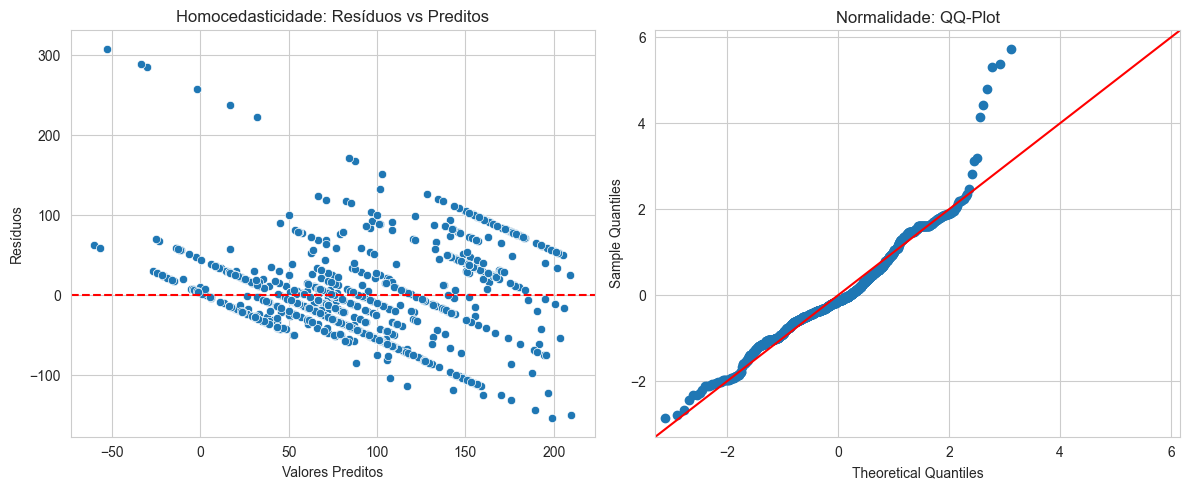

Teste de Normalidade (Shapiro-Wilk): P-Valor = 1.2648e-17


In [8]:
# Diagnóstico de Resíduos (Obrigatório na Ementa)
residuals = model_ols.resid
fitted = model_ols.fittedvalues

plt.figure(figsize=(12, 5))

# 1. Homocedasticidade (Resíduos vs Preditos)
plt.subplot(1, 2, 1)
sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Homocedasticidade: Resíduos vs Preditos')

# 2. Normalidade (QQ-Plot)
plt.subplot(1, 2, 2)
sm.qqplot(residuals, line='45', fit=True, ax=plt.gca())
plt.title('Normalidade: QQ-Plot')

plt.tight_layout()
plt.show()

# Teste de Shapiro-Wilk para confirmar normalidade (Opcional, mas impressiona)
stat, p_val = stats.shapiro(residuals)
print(f"Teste de Normalidade (Shapiro-Wilk): P-Valor = {p_val:.4e}")

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# --- 4.1. COMPARAÇÃO: REGRESSÃO POLINOMIAL ---
# A ementa pede para testar regressão polinomial. Vamos ver se grau 2 melhora o resultado.

print("--- Treinando Regressão Polinomial (Grau 2) ---")

# Criar pipeline: Gera features polinomiais -> Aplica Regressão Linear
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)

# Previsão
y_pred_poly = poly_model.predict(X_test)

# Métricas Polinomial
# Nota: Se o seu sklearn for antigo, mantivemos o cálculo manual do RMSE
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"R² Polinomial: {r2_poly:.4f}")
print(f"RMSE Polinomial: {rmse_poly:.2f}")

# Comparação com o modelo Linear anterior (OLS)
r2_linear = r2_score(y_test, y_pred) # y_pred vem da célula anterior

print("\n--- Veredito: Linear vs Polinomial ---")
if r2_poly > r2_linear:
    print(f"A Regressão Polinomial foi MELHOR (R² {r2_poly:.4f} vs {r2_linear:.4f}).")
    print("Isso indica relações não-lineares entre os status e a taxa de captura.")
else:
    print(f"A Regressão Linear foi MELHOR ou IGUAL (R² {r2_linear:.4f} vs {r2_poly:.4f}).")
    print("O modelo mais simples é preferível (Navalha de Ockham).")

--- Treinando Regressão Polinomial (Grau 2) ---
R² Polinomial: 0.4729
RMSE Polinomial: 59.40

--- Veredito: Linear vs Polinomial ---
A Regressão Polinomial foi MELHOR (R² 0.4729 vs 0.4285).
Isso indica relações não-lineares entre os status e a taxa de captura.


--- Naive Bayes ---
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       260
           1       0.42      0.65      0.51        17

    accuracy                           0.92       277
   macro avg       0.70      0.79      0.74       277
weighted avg       0.94      0.92      0.93       277


Melhores Parâmetros: {'C': 1, 'solver': 'liblinear'}

--- Regressão Logística Otimizada ---
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       260
           1       0.90      0.53      0.67        17

    accuracy                           0.97       277
   macro avg       0.94      0.76      0.82       277
weighted avg       0.97      0.97      0.96       277



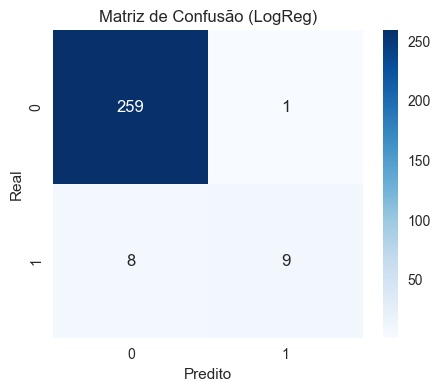

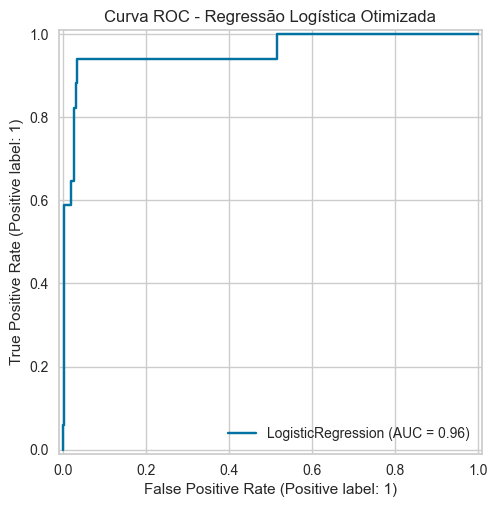

In [13]:
# Preparar dados para Classificação
from sklearn.metrics import RocCurveDisplay
X_cls = df_model[numeric_features]
y_cls = df_model[target_clf]

# Divisão Estratificada (mantém proporção de lendários)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

# Padronização (Crucial para Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_c)
X_test_scaled = scaler.transform(X_test_c)

# 1. Naive Bayes (Baseline)
nb = GaussianNB()
nb.fit(X_train_c, y_train_c)
y_pred_nb = nb.predict(X_test_c)
print("--- Naive Bayes ---\n", classification_report(y_test_c, y_pred_nb))

# 2. Otimização de Regressão Logística (GridSearch)
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}
grid = GridSearchCV(LogisticRegression(max_iter=2000), param_grid, cv=5, scoring='f1')
grid.fit(X_train_scaled, y_train_c)

print(f"\nMelhores Parâmetros: {grid.best_params_}")
best_model = grid.best_estimator_

# Avaliação Final
y_pred_best = best_model.predict(X_test_scaled)
print("\n--- Regressão Logística Otimizada ---\n", classification_report(y_test_c, y_pred_best))

# Matriz de Confusão
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_c, y_pred_best), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão (LogReg)')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()

# Plotar Curva ROC
RocCurveDisplay.from_estimator(best_model, X_test_scaled, y_test_c)
plt.title("Curva ROC - Regressão Logística Otimizada")
plt.show()

In [11]:
from pycaret.regression import setup as setup_reg
from pycaret.regression import compare_models as compare_reg
from pycaret.regression import tune_model as tune_reg
from pycaret.regression import pull as pull_reg

print("--- Otimização com PyCaret (Regressão) ---")
# Setup do PyCaret (automático)
reg_experiment = setup_reg(data=df_model, target='CatchRate', session_id=42, verbose=False)

# Comparar modelos
best_reg = compare_reg(sort='R2', n_select=1)
print(pull_reg())

# Tunar o melhor modelo
tuned_reg = tune_reg(best_reg, optimize='R2')

--- Otimização com PyCaret (Regressão) ---


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,36.3768,2812.2501,52.7778,0.4775,0.7523,1.1134,0.0320
huber,Huber Regressor,43.4256,3409.6754,58.1592,0.3701,0.9223,1.5968,0.0400
omp,Orthogonal Matching Pursuit,45.0446,3637.6083,60.1675,0.3269,0.9473,1.9555,0.0350
br,Bayesian Ridge,44.5380,3642.6995,60.2316,0.3247,0.9362,2.0341,0.0340
ridge,Ridge Regression,44.5470,3651.0247,60.3056,0.3227,0.9325,2.0594,0.0340
lr,Linear Regression,44.6413,3657.6986,60.3629,0.3213,0.9339,2.0677,0.4480
en,Elastic Net,45.2662,3679.0480,60.5184,0.3187,0.9357,1.9963,0.0340
llar,Lasso Least Angle Regression,45.5767,3731.2043,60.9475,0.3089,0.9333,2.0148,0.0360
lasso,Lasso Regression,45.5767,3731.2091,60.9476,0.3089,0.9333,2.0148,0.2460
et,Extra Trees Regressor,41.3870,3745.3539,61.0799,0.3058,0.8816,1.8581,0.1030


                                    Model           MAE            MSE  \
knn                 K Neighbors Regressor  3.637680e+01   2.812250e+03   
huber                     Huber Regressor  4.342560e+01   3.409675e+03   
omp           Orthogonal Matching Pursuit  4.504460e+01   3.637608e+03   
br                         Bayesian Ridge  4.453800e+01   3.642700e+03   
ridge                    Ridge Regression  4.454700e+01   3.651025e+03   
lr                      Linear Regression  4.464130e+01   3.657699e+03   
en                            Elastic Net  4.526620e+01   3.679048e+03   
llar         Lasso Least Angle Regression  4.557670e+01   3.731204e+03   
lasso                    Lasso Regression  4.557670e+01   3.731209e+03   
et                  Extra Trees Regressor  4.138700e+01   3.745354e+03   
lightgbm  Light Gradient Boosting Machine  4.360250e+01   4.034952e+03   
gbr           Gradient Boosting Regressor  4.359500e+01   4.046321e+03   
rf                Random Forest Regres

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,32.2858,2318.7910,48.1538,0.5787,0.7684,1.0107
1,29.3725,1891.8473,43.4954,0.5168,0.8601,1.6208
2,35.0009,2363.3491,48.6143,0.6123,0.6067,0.7878
3,31.7198,2500.4437,50.0044,0.5454,0.7050,0.9743
4,35.8413,2351.0703,48.4878,0.6108,0.6958,1.0071
5,36.8589,2645.4870,51.4343,0.5301,0.9372,1.8714
6,34.0967,2393.1471,48.9198,0.4904,0.6549,0.8118
7,35.9636,2428.5145,49.2800,0.5546,0.6786,0.8960
8,36.6299,3304.6660,57.4862,0.4248,0.6996,0.9242


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [12]:
from pycaret.classification import setup as setup_clf
from pycaret.classification import compare_models as compare_clf
from pycaret.classification import tune_model as tune_clf
from pycaret.classification import pull as pull_clf

print("--- Otimização com PyCaret (Classificação) ---")
clf_experiment = setup_clf(data=df_model, target='is_legendary', session_id=42, fix_imbalance=True, verbose=False)

# Comparar modelos
best_clf = compare_clf(sort='F1', n_select=1)
print(pull_clf())

# Tunar o melhor modelo
tuned_clf = tune_clf(best_clf, optimize='F1')

--- Otimização com PyCaret (Classificação) ---


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.9000,0.9000,0.9000,0.9000,0.9000,0.9000,0.9000,0.0410
et,Extra Trees Classifier,0.8794,0.9000,0.5714,0.9000,0.6885,0.6787,0.7031,0.0570
lr,Logistic Regression,0.8587,0.8882,0.8000,0.5595,0.6412,0.6202,0.6419,0.0660
nb,Naive Bayes,0.8504,0.8864,0.7881,0.5200,0.6134,0.5886,0.6112,0.0410
rf,Random Forest Classifier,0.8732,0.8996,0.4762,0.9000,0.6052,0.5936,0.6351,0.0730
dt,Decision Tree Classifier,0.8721,0.6798,0.4595,0.9000,0.5942,0.5821,0.6250,0.0420
ada,Ada Boost Classifier,0.8721,0.6798,0.4595,0.9000,0.5942,0.5821,0.6250,0.0330
gbc,Gradient Boosting Classifier,0.8721,0.6793,0.4595,0.9000,0.5942,0.5821,0.6250,0.0770
lda,Linear Discriminant Analysis,0.8721,0.7897,0.4595,0.9000,0.5942,0.5821,0.6250,0.0350
lightgbm,Light Gradient Boosting Machine,0.8721,0.7034,0.4595,0.9000,0.5942,0.5821,0.6250,0.0810


                                    Model  Accuracy     AUC  Recall   Prec.  \
ridge                    Ridge Classifier    0.9000  0.9000  0.9000  0.9000   
et                 Extra Trees Classifier    0.8794  0.9000  0.5714  0.9000   
lr                    Logistic Regression    0.8587  0.8882  0.8000  0.5595   
nb                            Naive Bayes    0.8504  0.8864  0.7881  0.5200   
rf               Random Forest Classifier    0.8732  0.8996  0.4762  0.9000   
dt               Decision Tree Classifier    0.8721  0.6798  0.4595  0.9000   
ada                  Ada Boost Classifier    0.8721  0.6798  0.4595  0.9000   
gbc          Gradient Boosting Classifier    0.8721  0.6793  0.4595  0.9000   
lda          Linear Discriminant Analysis    0.8721  0.7897  0.4595  0.9000   
lightgbm  Light Gradient Boosting Machine    0.8721  0.7034  0.4595  0.9000   
knn                K Neighbors Classifier    0.8329  0.8466  0.7762  0.4126   
qda       Quadratic Discriminant Analysis    0.8473 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
